In [1]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm
import theano.tensor as tt

import matplotlib.dates as mdates
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler, scale
import pickle
from collections import namedtuple
from numpy import pi as PI

In [2]:
%matplotlib inline

As a first attempt I am going to model the timeseries using a Gaussian Random Walk.
I am also going to impute the missing data by modeling it

In [3]:
years = mdates.YearLocator(day=15)
months = mdates.MonthLocator(bymonthday=15)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-3, 2)

In [4]:
proj_path = pathlib.Path('~/PROJEX/SouthernOcean/')
proj_path.exists()

False

In [5]:
#chl_file_path = proj_path / 'dataJar/seawifs_chl_monthly_15sosectors_repro2018.dat'
#df = pd.read_csv(chl_file_path, delim_whitespace=True, parse_dates=[[0, 1 ,2]], index_col=0)
df = pd.read_pickle('../../pickleJar/df.pkl')
#df.index.name=''
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1997-09-01 to 2018-04-01
Data columns (total 14 columns):
sam        248 non-null float64
aao        248 non-null float64
iostz      248 non-null float64
iosostz    248 non-null float64
postz      248 non-null float64
posostz    248 non-null float64
aostz      248 non-null float64
aosostz    248 non-null float64
iopooz     241 non-null float64
popooz     188 non-null float64
aopooz     248 non-null float64
iosaaz     248 non-null float64
posaaz     248 non-null float64
aosaaz     248 non-null float64
dtypes: float64(14)
memory usage: 29.1 KB


In [6]:
df.head()

sam    aao   iostz   iosostz    postz  posostz    aostz  aosostz  \
date                                                                            
1997-09-01  0.69  0.122  0.24396  0.19464  0.23765  0.15677  0.35295  0.21213   
1997-10-01 -1.78 -0.595  0.23801  0.18567  0.25429  0.15624  0.33579  0.24524   
1997-11-01 -3.17 -1.905  0.22475  0.21562  0.22035  0.20676  0.31870  0.31555   
1997-12-01 -0.89 -0.835  0.22303  0.26677  0.19563  0.43561  0.27345  0.61580   
1998-01-01  2.65  0.413  0.17366  0.23300  0.16382  0.30970  0.25799  0.46643   

              iopooz   popooz    aopooz   iosaaz   posaaz   aosaaz   
date                                                                 
1997-09-01  0.180950  0.154737  0.194558  0.19830  0.16906  0.28457  
1997-10-01  0.195581  0.163974  0.235877  0.20853  0.15947  0.35077  
1997-11-01  0.221278  0.232293  0.277545  0.25616  0.17670  0.45735  
1997-12-01  0.275540  0.301326  0.388892  0.24011  0.18865  0.44453  
1998-01-01  0.199565  0.194234  0.371978  0.21664  0.13944  0.43567

In [7]:
df.rename(columns={col: col.strip() for col in df.columns}, inplace=True)

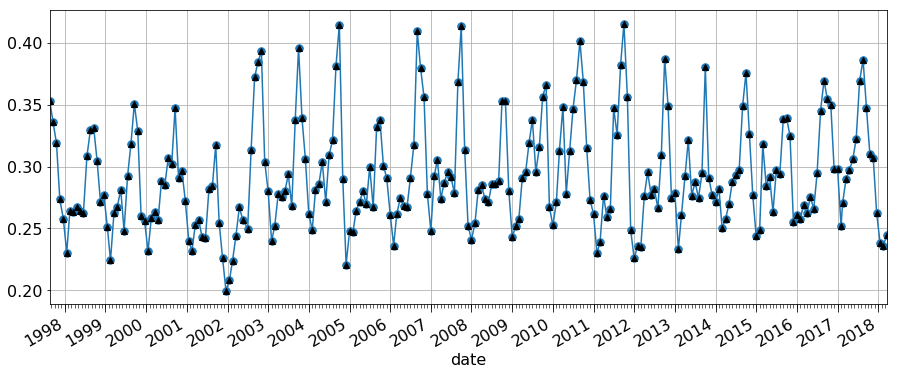

In [8]:
_, ax = pl.subplots(figsize=(15, 6))
df.aostz.plot(marker='.', ax=ax, markersize=15)
df.aostz.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

In [9]:
d_aostz = df['aostz'].resample('MS').mean().interpolate()
d_aostz.shape

(248,)

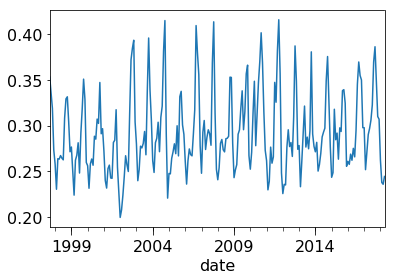

In [10]:
d_aostz.plot();

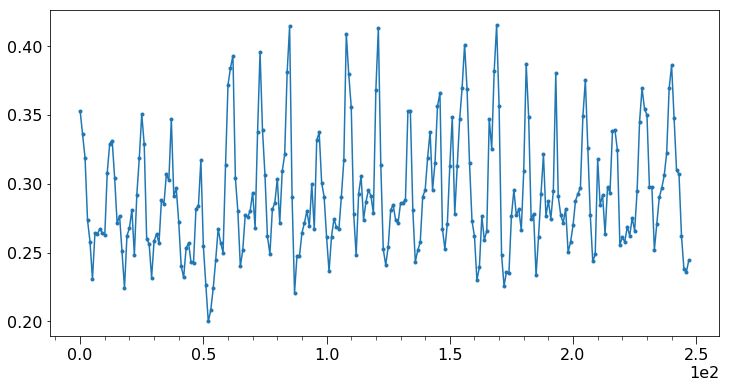

In [11]:
y = d_aostz.values
wl = 12/(2*np.pi)
x = np.arange(y.size)
f = pl.figure(figsize=(12, 6))
pl.plot(x, y, marker='.');

#### <u>Standardizing the Data</u>

In [12]:
std_scaler = StandardScaler()
y_s = std_scaler.fit_transform(y.reshape(-1, 1))
y_s = y_s.flatten()

In [208]:
def mdl_trend_only(m):
    with m:
        σ = pm.Exponential('σ', 1)
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        
        μ = beta0 + beta1 * x
        y_lik = pm.Normal('y_lik', mu=μ, sd=sig, observed=y_s)

def fourier_series(x, p=12, n=1):
    wls = 2 * np.pi * np.arange(1, n+1) / p
    newx = wls * x[:, None]
    sinusoids = np.concatenate((np.cos(newx), np.sin(newx)), axis=1)
    return sinusoids

def mdl_season_only(m, n_fourier):
    with m:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        #tau = pm.Gamma('tau', 10, 2) 
        #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
        y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)
        
def mdl_trend_season(m, n_fourier):
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)

        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

def mdl_trend_season_ar1(m, n_fourier):
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)
        
        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
        
        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season + ar1)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

In [195]:
m = pm.Model()

In [196]:
mdl_trend_season(m, n_fourier=3)

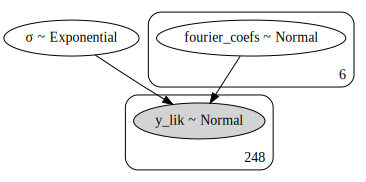

In [197]:
pm.model_to_graphviz(m)

In [198]:
with m:
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:06<00:00, 3751.35draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0156e9d668>,
      dtype=object)

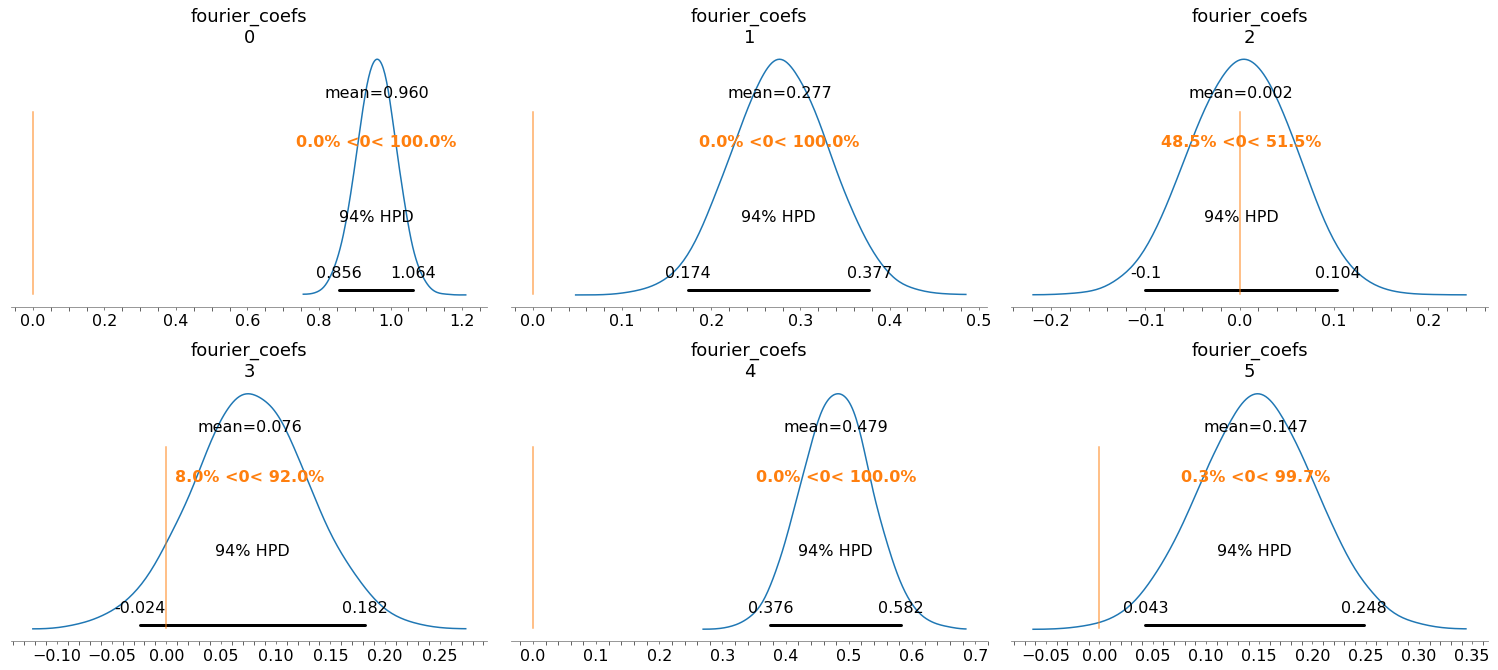

In [199]:
pm.plot_posterior(trace, var_names='fourier_coefs', ref_val=0, round_to=3)

In [201]:
ppc = pm.sample_posterior_predictive(trace, model=m)

100%|██████████| 20000/20000 [00:12<00:00, 1558.06it/s]


In [164]:
t = np.arange(10)

In [187]:
N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array(np.cos(wls*t[:,None]), np.sin(wls*t[:,None]))

TypeError: data type not understood

In [186]:
sinusoids.squeeze()

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 8.66025404e-01,  5.00000000e-01,  6.12323400e-17],
        [ 5.00000000e-01, -5.00000000e-01, -1.00000000e+00],
        [ 6.12323400e-17, -1.00000000e+00, -1.83697020e-16],
        [-5.00000000e-01, -5.00000000e-01,  1.00000000e+00],
        [-8.66025404e-01,  5.00000000e-01,  3.06161700e-16],
        [-1.00000000e+00,  1.00000000e+00, -1.00000000e+00],
        [-8.66025404e-01,  5.00000000e-01, -4.28626380e-16],
        [-5.00000000e-01, -5.00000000e-01,  1.00000000e+00],
        [-1.83697020e-16, -1.00000000e+00,  5.51091060e-16]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.00000000e-01,  8.66025404e-01,  1.00000000e+00],
        [ 8.66025404e-01,  8.66025404e-01,  1.22464680e-16],
        [ 1.00000000e+00,  1.22464680e-16, -1.00000000e+00],
        [ 8.66025404e-01, -8.66025404e-01, -2.44929360e-16],
        [ 5.00000000e-01, -8.66025404e-01,  1.00000000e+00],
        [ 1.22464680e-

In [169]:
fourier_series(t, n=N)

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.66025404e-01,  5.00000000e-01,  6.12323400e-17,
         5.00000000e-01,  8.66025404e-01,  1.00000000e+00],
       [ 5.00000000e-01, -5.00000000e-01, -1.00000000e+00,
         8.66025404e-01,  8.66025404e-01,  1.22464680e-16],
       [ 6.12323400e-17, -1.00000000e+00, -1.83697020e-16,
         1.00000000e+00,  1.22464680e-16, -1.00000000e+00],
       [-5.00000000e-01, -5.00000000e-01,  1.00000000e+00,
         8.66025404e-01, -8.66025404e-01, -2.44929360e-16],
       [-8.66025404e-01,  5.00000000e-01,  3.06161700e-16,
         5.00000000e-01, -8.66025404e-01,  1.00000000e+00],
       [-1.00000000e+00,  1.00000000e+00, -1.00000000e+00,
         1.22464680e-16, -2.44929360e-16,  3.67394040e-16],
       [-8.66025404e-01,  5.00000000e-01, -4.28626380e-16,
        -5.00000000e-01,  8.66025404e-01, -1.00000000e+00],
       [-5.00000000e-01, -5.00000000e-01,  1.000

In [180]:
np.testing.assert_array_equal(sinusoids.squeeze(), fourier_series(t, n=N))

AssertionError: 
Arrays are not equal

(shapes (10, 2, 3), (10, 6) mismatch)
 x: array([[[ 1.000000e+00,  1.000000e+00,  1.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00]],
...
 y: array([[ 1.000000e+00,  1.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 8.660254e-01,  5.000000e-01,  6.123234e-17,  5.000000e-01,...

In [150]:
(wls * x[:, None]).shape

(248, 3)

In [147]:
sinusoids

array([[ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 8.66025404e-01,  5.00000000e-01,  5.00000000e-01,
         8.66025404e-01,  6.12323400e-17,  1.00000000e+00],
       [ 5.00000000e-01,  8.66025404e-01, -5.00000000e-01,
         8.66025404e-01, -1.00000000e+00,  1.22464680e-16],
       ...,
       [-8.66025404e-01,  5.00000000e-01,  5.00000000e-01,
        -8.66025404e-01,  1.32255665e-14,  1.00000000e+00],
       [-1.00000000e+00,  1.56791929e-14,  1.00000000e+00,
        -3.13583858e-14, -1.00000000e+00,  1.86158693e-14],
       [-8.66025404e-01, -5.00000000e-01,  5.00000000e-01,
         8.66025404e-01, -2.40061722e-14, -1.00000000e+00]])

In [146]:
2 * np.pi * np.arange(1, N+1) / 12

array([0.52359878, 1.04719755, 1.57079633])

### Modeling Trends
#### <u>Basic Trend Models</u>

In [136]:
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [138]:
beta = np.random.normal(size=2*4)

In [139]:
beta

array([ 1.28292379,  1.38174553,  0.57865272, -0.27670873,  0.30248946,
        0.44985474, -0.03127546,  0.60834771])

In [143]:
fourier_series(t=np.arange(10), n=4)@beta

array([2.96661332, 3.02638152, 3.08368998, 3.13832606, 3.190079  ,
       3.23874088, 3.28410762, 3.32597992, 3.36416428, 3.39847389])

In [116]:
with pm.Model() as m1:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

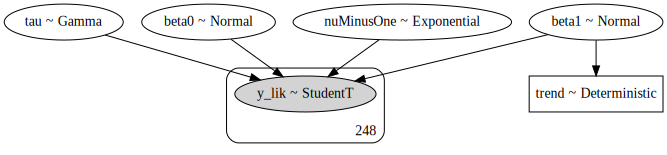

In [14]:
pm.model_to_graphviz(m1)

In [117]:
with m1:
    trace1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau, nuMinusOne]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:12<00:00, 1937.10draws/s]


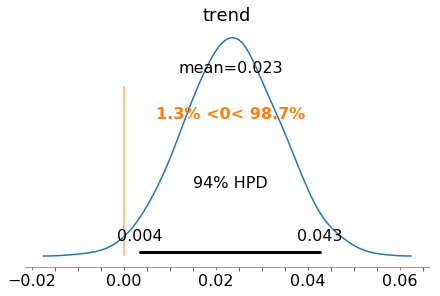

In [118]:
pm.plot_posterior(trace1, var_names=['trend'], round_to=3, ref_val=0);

In [113]:
with pm.Model() as m1n:
    sig = pm.HalfNormal('sig', 5)
    beta1 = pm.Normal('beta1', 0, 1)
    beta0 = pm.Normal('beta0', 0, 1)
    
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.Normal('y_lik', mu=mu_, sd=sig, observed=y_s)

In [114]:
with m1n:
    trace_1n = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sig]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:09<00:00, 2435.66draws/s]


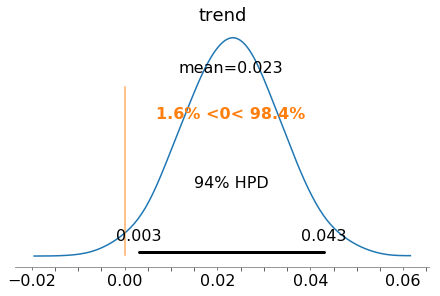

In [115]:
pm.plot_posterior(trace_1n, var_names=['trend'], round_to=3, ref_val=0);

In [119]:
m1.name = 'm1_trend_only'
m1n.name = 'm1n_trend_only'

In [120]:
pm.compare({m1: trace1, m1n: trace_1n})

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


WAIC pWAIC dWAIC weight     SE   dSE var_warn
m1n_trend_only   704.9   2.9     0   0.67  23.14     0        0
m1_trend_only   705.18  3.34  0.28   0.33  23.91  1.81        0

A Gaussian for the likelihood seems to make sense here. 
Create dictionary to hold models for final comparison:

In [121]:
dict_compare_final = {m1n: trace_1n}

### Seasonality

#### <u>Seasonality based on Fourier Series</u>

In [123]:

N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_f3:
    #nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    #nu_ = nuMinusOne + 1
    σ = pm.Exponential('σ', 1)
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    #tau = pm.Gamma('tau', 10, 2) 
    #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
    y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

In [124]:
with m2_f3:
    trace_m2f = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:09<00:00, 4411.16draws/s]


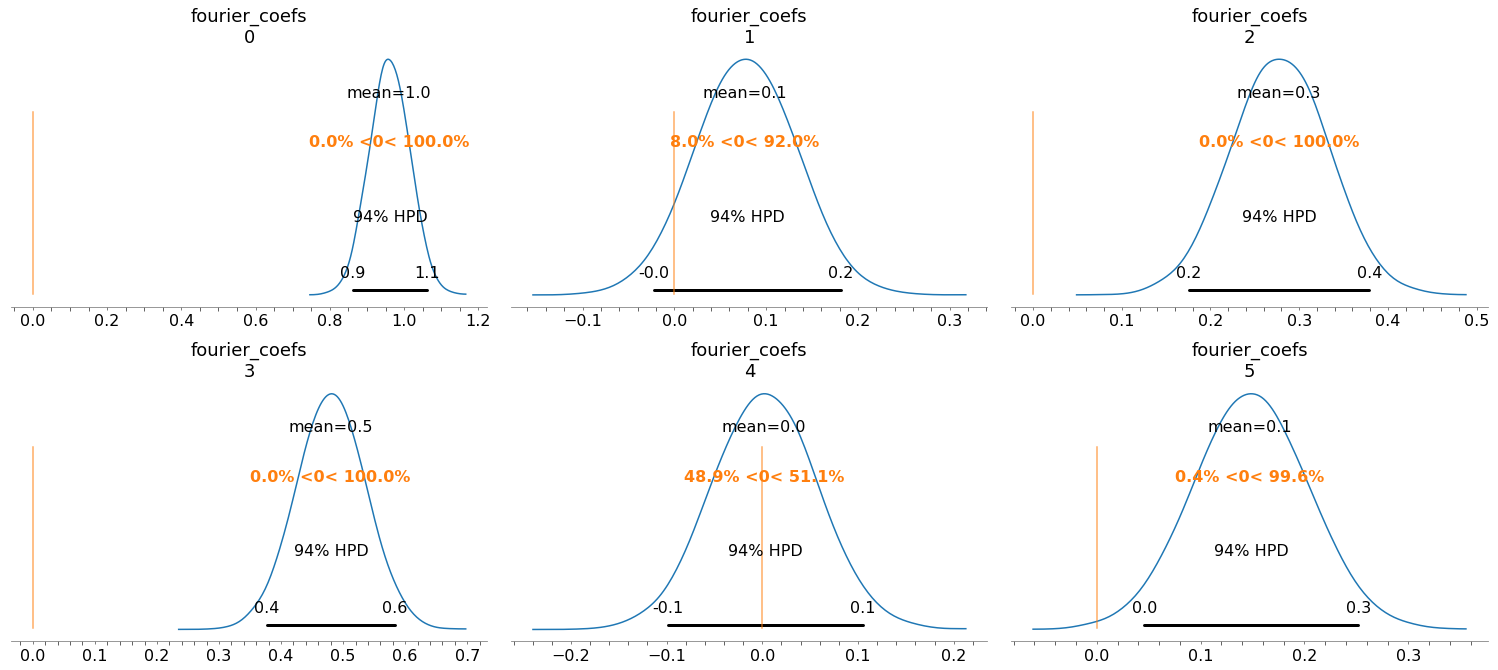

In [125]:
pm.plot_posterior(trace_m2f, var_names=['fourier_coefs'], ref_val=0);

In [126]:
N=5
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_f5:
    #nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    #nu_ = nuMinusOne + 1
    σ = pm.Exponential('σ', 1)
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    #tau = pm.Gamma('tau', 10, 2) 
    #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
    y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

In [127]:
with m2_f5:
    trace_m2f5 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:14<00:00, 2716.68draws/s]


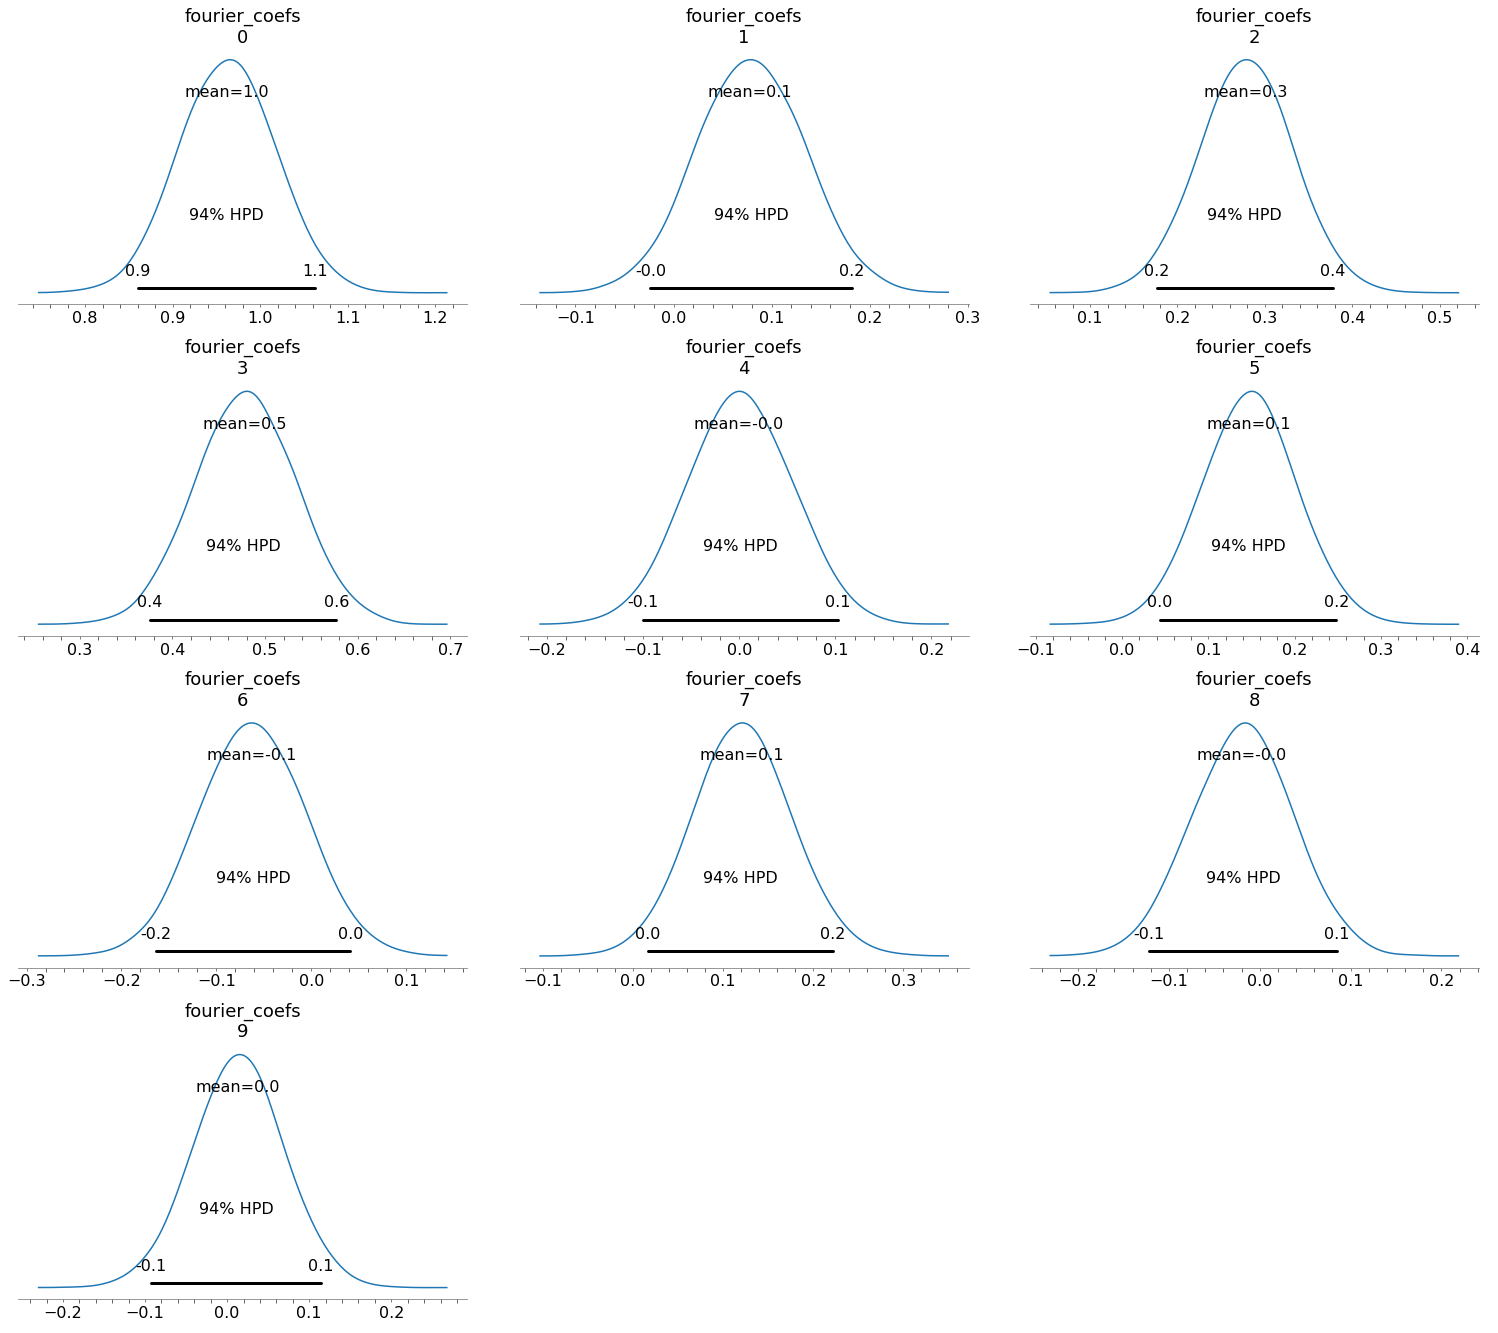

In [128]:
pm.plot_posterior(trace_m2f5, var_names=['fourier_coefs']);

In [129]:
N=7
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_f7:
    #nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    #nu_ = nuMinusOne + 1
    σ = pm.Exponential('σ', 1)
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    #tau = pm.Gamma('tau', 10, 2) 
    #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
    y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

In [130]:
with m2_f7:
    trace_m2f7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:54<00:00, 740.10draws/s]


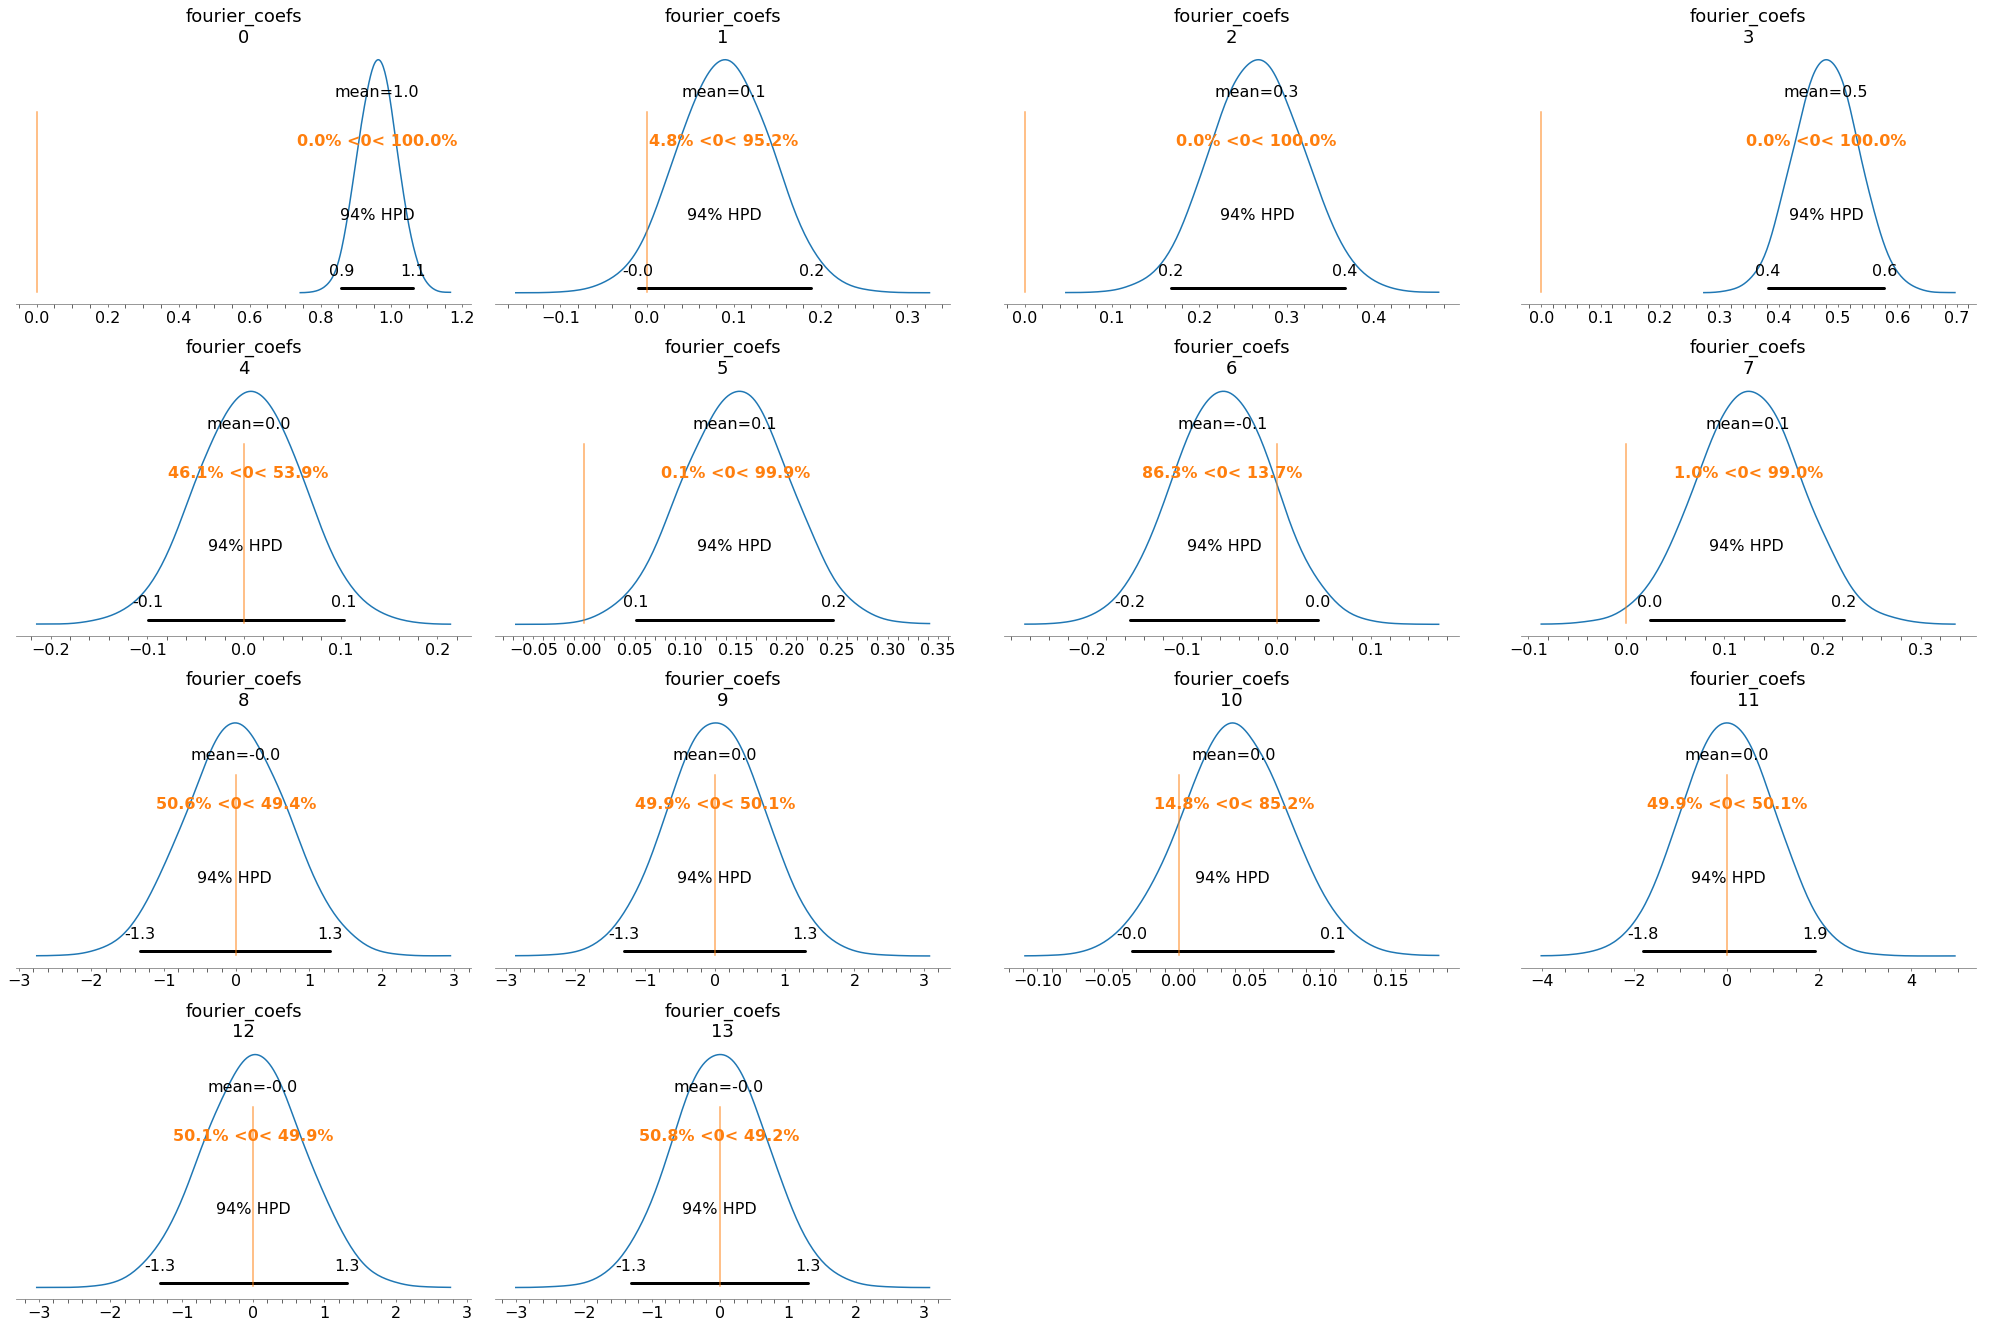

In [40]:
pm.plot_posterior(trace_m2f7, var_names=['fourier_coefs'], ref_val=0);

In [41]:
N=4
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_f4:
    #nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    #nu_ = nuMinusOne + 1
    σ = pm.Exponential('σ', 1)
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    #tau = pm.Gamma('tau', 10, 2) 
    #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
    y_lik

In [42]:
with m2_fourier_4:
    trace_m2f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, fourier_coefs, nuMinusOne]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:12<00:00, 3203.48draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


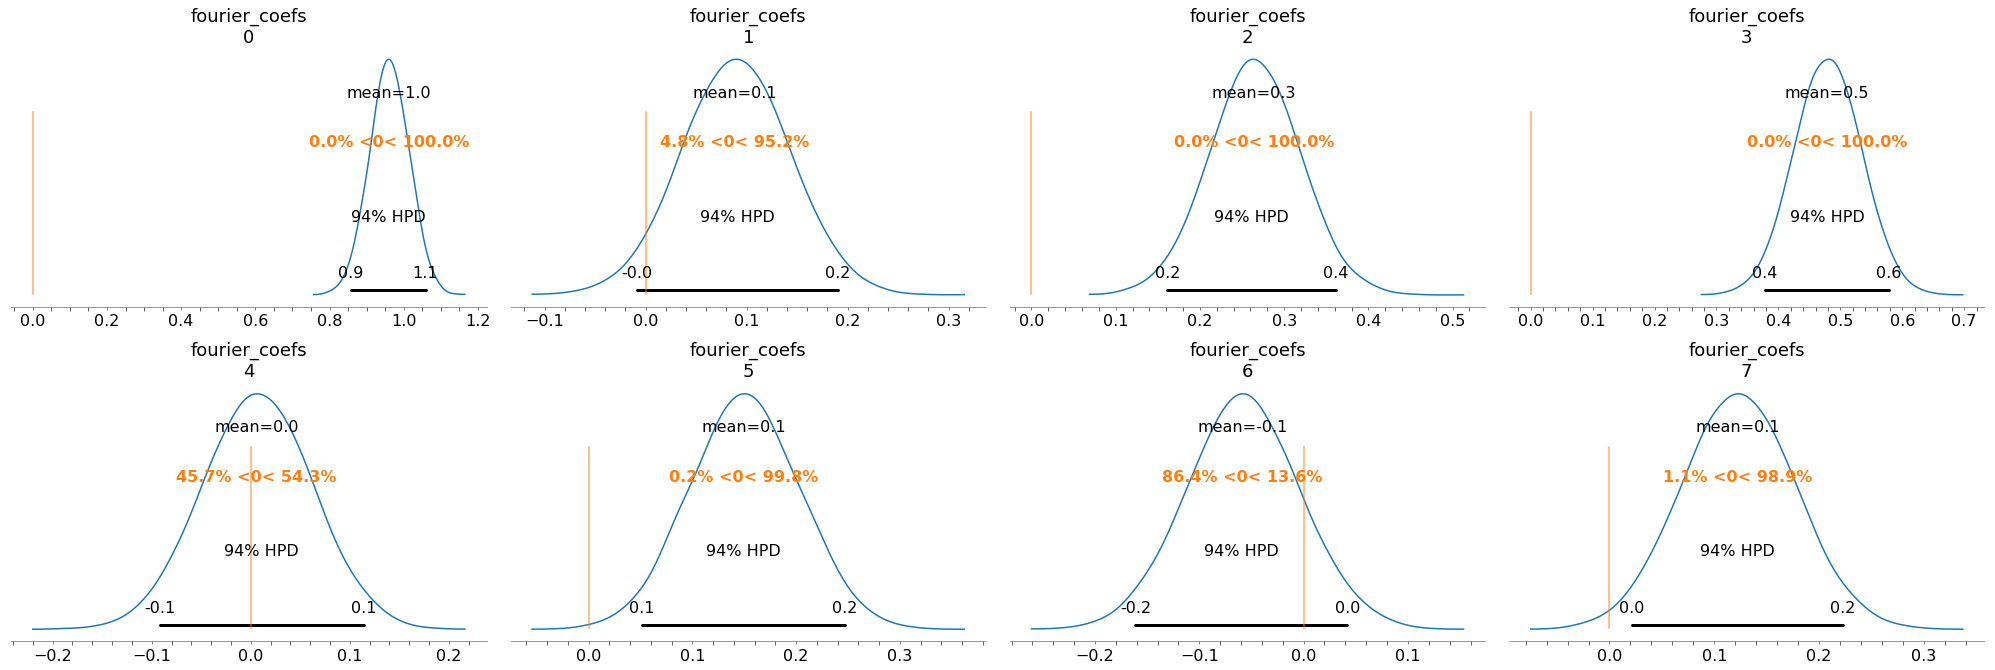

In [43]:
pm.plot_posterior(trace_m2f4, var_names=['fourier_coefs'], ref_val=0);

In [44]:
N=1
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier_1:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [45]:
with m2_fourier_1:
    trace_m2f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, fourier_coefs, nuMinusOne]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:10<00:00, 3929.60draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


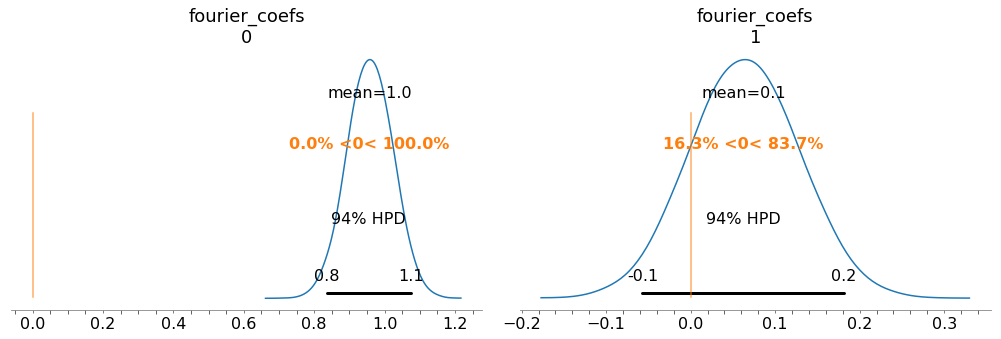

In [46]:
pm.plot_posterior(trace_m2f1, var_names=['fourier_coefs'], ref_val=0);

In [ ]:
m2_fourier_1.name = 'm_fourier_N1'
m2_fourier.name = 'm_fourier_N3'
m2_fourier_2.name = 'm_fourier_N5'
m2_fourier_3.name = 'm_fourier_N7'
m2_fourier_4.name = 'm_fourier_N4'

In [85]:
dict_compare_fourier = {m2_fourier: trace_m2f, m2_fourier_2: trace_m2f2,
           m2_fourier_3: trace_m2f3, m2_fourier_4: trace_m2f4,
           m2_fourier_1: trace_m2f1}

In [86]:
pm.compare(dict_compare_fourier)

WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
m_fourier_N4  461.86   9.72      0   0.64  24.99      0        0
m_fourier_N3  463.81   7.35   1.95   0.34  24.79   5.21        0
m_fourier_N5  465.39  11.53   3.53      0  24.93   0.96        0
m_fourier_N7  466.56  12.68    4.7      0  25.16   2.11        0
m_fourier_N1  550.35   3.35  88.48   0.02  24.79  18.32        0

The table above confirms that a 4-component fourier series model approximates well the yearly seasonal cycle in the data, and the 3-component one is not too far behind. I'll therefore updata the comparison dictionary with these:

In [90]:
dict_compare_final.update({m2_fourier: trace_m2f, m2_fourier_4: trace_m2f4,})

### Trend + Seasonality

In [102]:
N=4
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m3_f4:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [103]:
with m3_f4:
    trace_3f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, nuMinusOne, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:18<00:00, 2114.88draws/s]


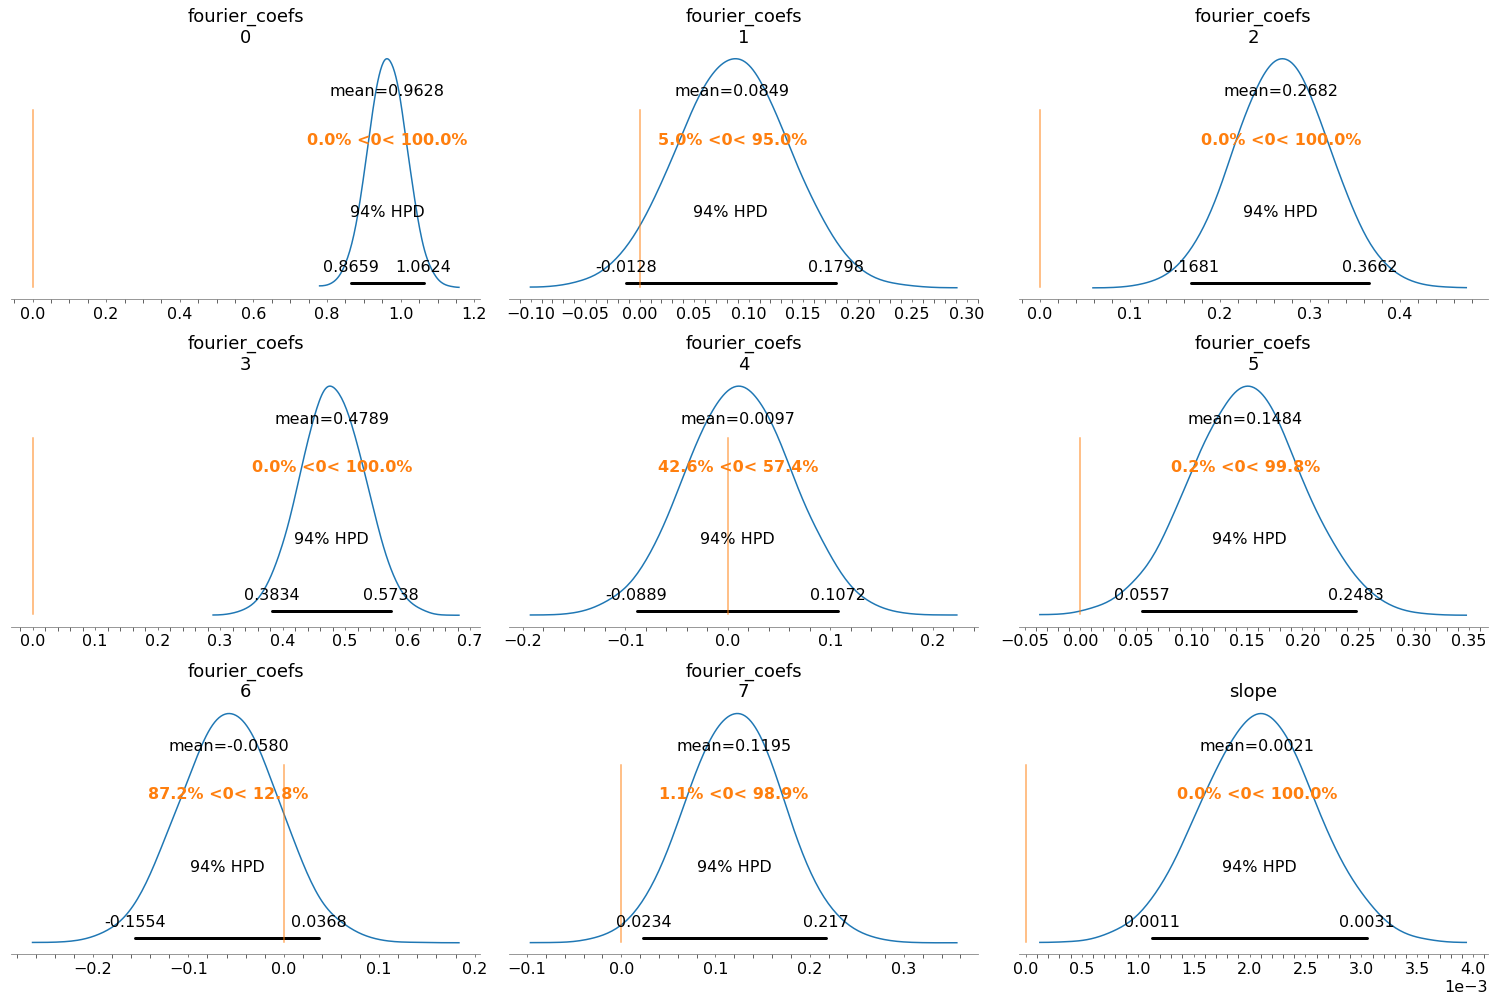

In [104]:
vars_ = ['fourier_coefs', 'slope',]
pm.plot_posterior(trace_3f4, var_names=vars_, ref_val=0, round_to=4);

In [105]:
N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T
with pm.Model() as m3_f3:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [106]:
with m3_f3:
    trace_3f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, nuMinusOne, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1978.66draws/s]


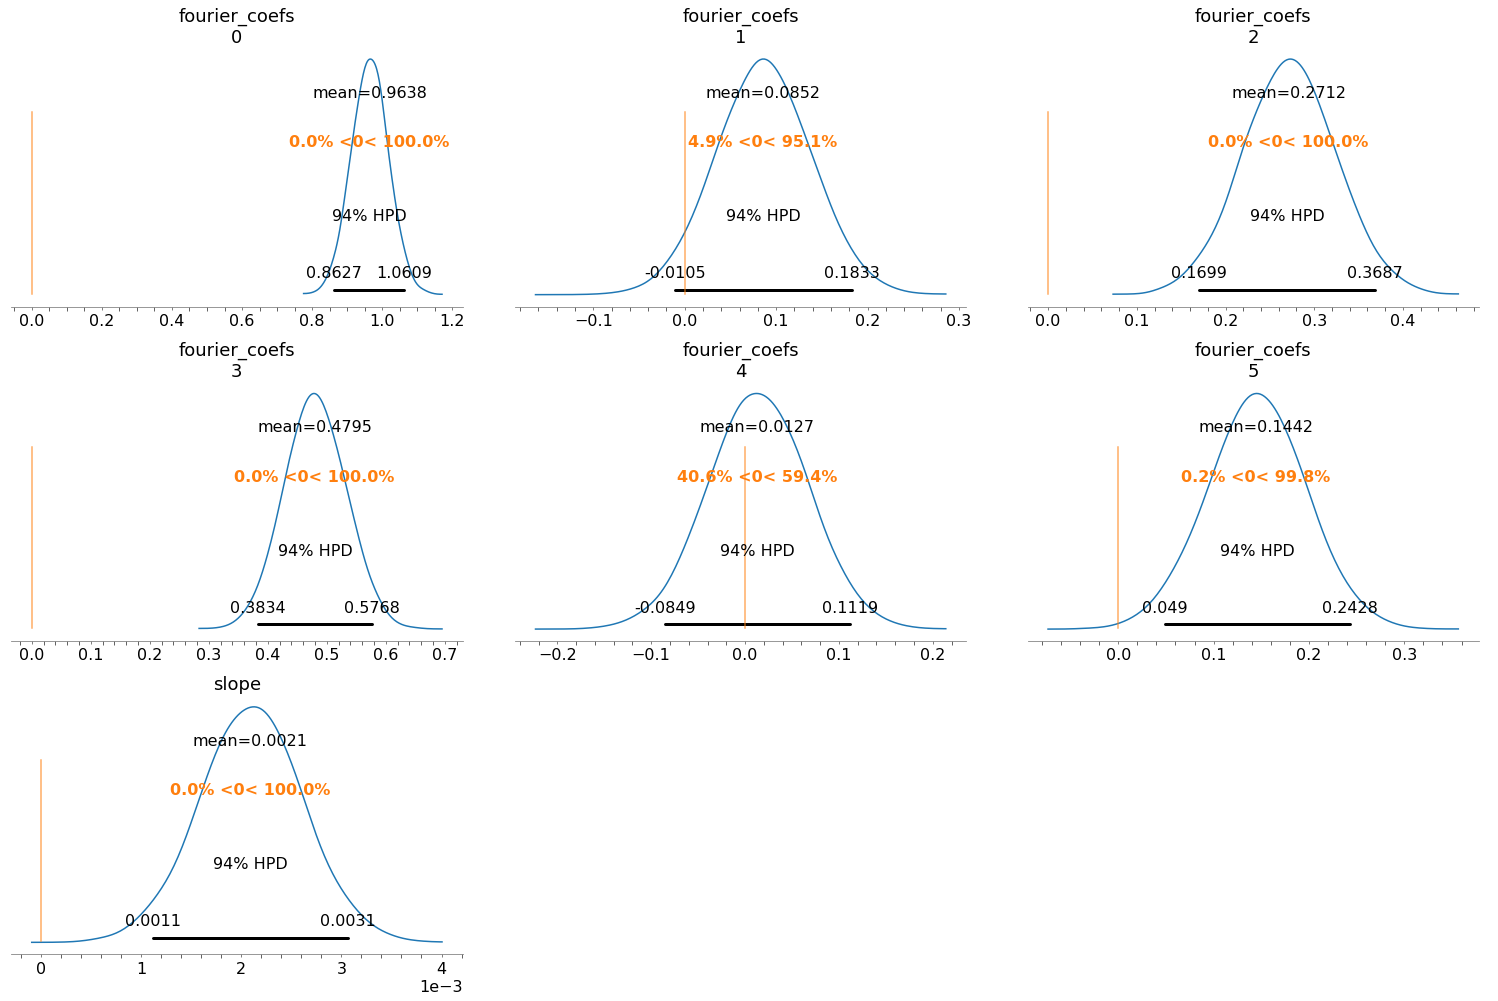

In [59]:
pm.plot_posterior(trace_3f3, var_names=vars_, ref_val=0, round_to=4);

In [100]:
m3_f1.name ='m3_trend&fourierN4'
m3_f3.name = 'm3_trend&fourierN3'

In [101]:
pm.compare({m3_f1: trace_3f1, m3_f3: trace_3f3, })

TypeError: Missing required input: k_interval__

The difference is not quite convincing so I'll keep both models for the overall comparison:

In [91]:
dict_compare_final.update({m3_f1: trace_3f1, m3_f3: trace_3f3, })

### Trend + Season + Residual

In [105]:
with pm.Model() as m4_normal:
    sd_ = pm.HalfCauchy('sd', 2.5)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.Normal('y_lik', mu=mu_, sd=sd_, observed=y_s)

In [64]:
N=4
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m4_f4:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [67]:
N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m4_f3:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [66]:
render_m4_normal = pm.model_to_graphviz(m4_f4)
render_m4_normal.format='png'
render_m4_normal.render('m4_f4_graph', directory='../../figjar/')

'../../figjar/m4_f4_graph.png'

<img src='../../figjar/m4_f4_graph.png'>

In [75]:
with m4_f4:
    trace4_f4 = pm.sample(7000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, nuMinusOne, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 88000/88000 [02:43<00:00, 537.41draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20991433534983167, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [76]:
with m4_f3:
    trace4_f3 = pm.sample(7000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, nuMinusOne, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 88000/88000 [02:33<00:00, 574.51draws/s]
The acceptance probability does not match the target. It is 0.6996326990671963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6347814750150342, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


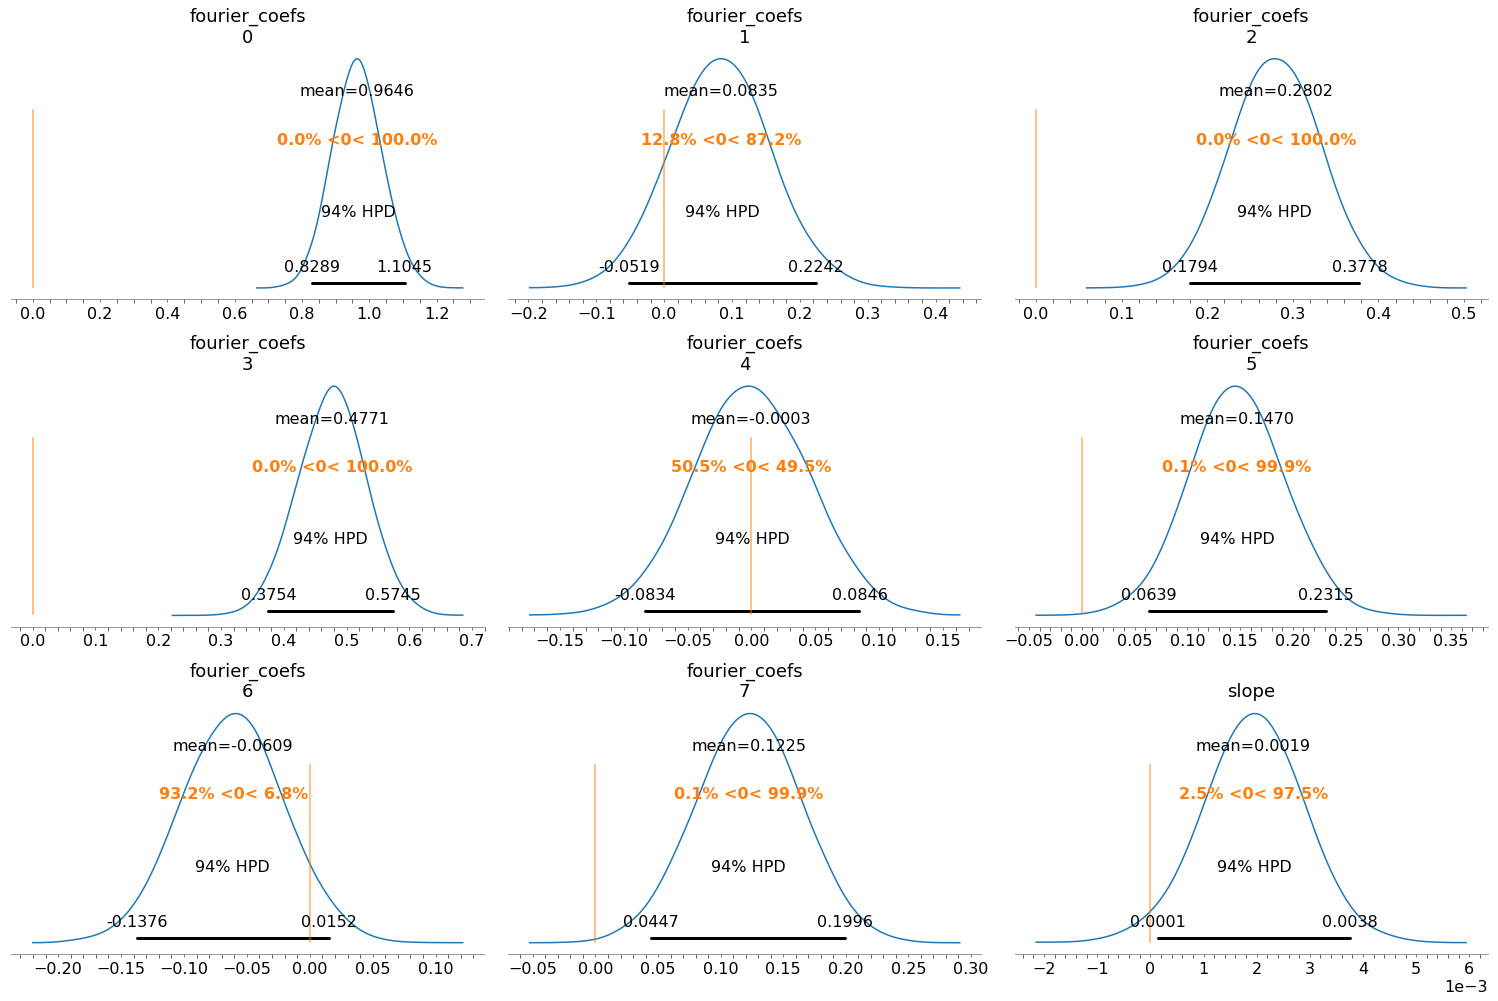

In [79]:
pm.plot_posterior(trace4_f4, var_names=vars_, ref_val=0, round_to=4);

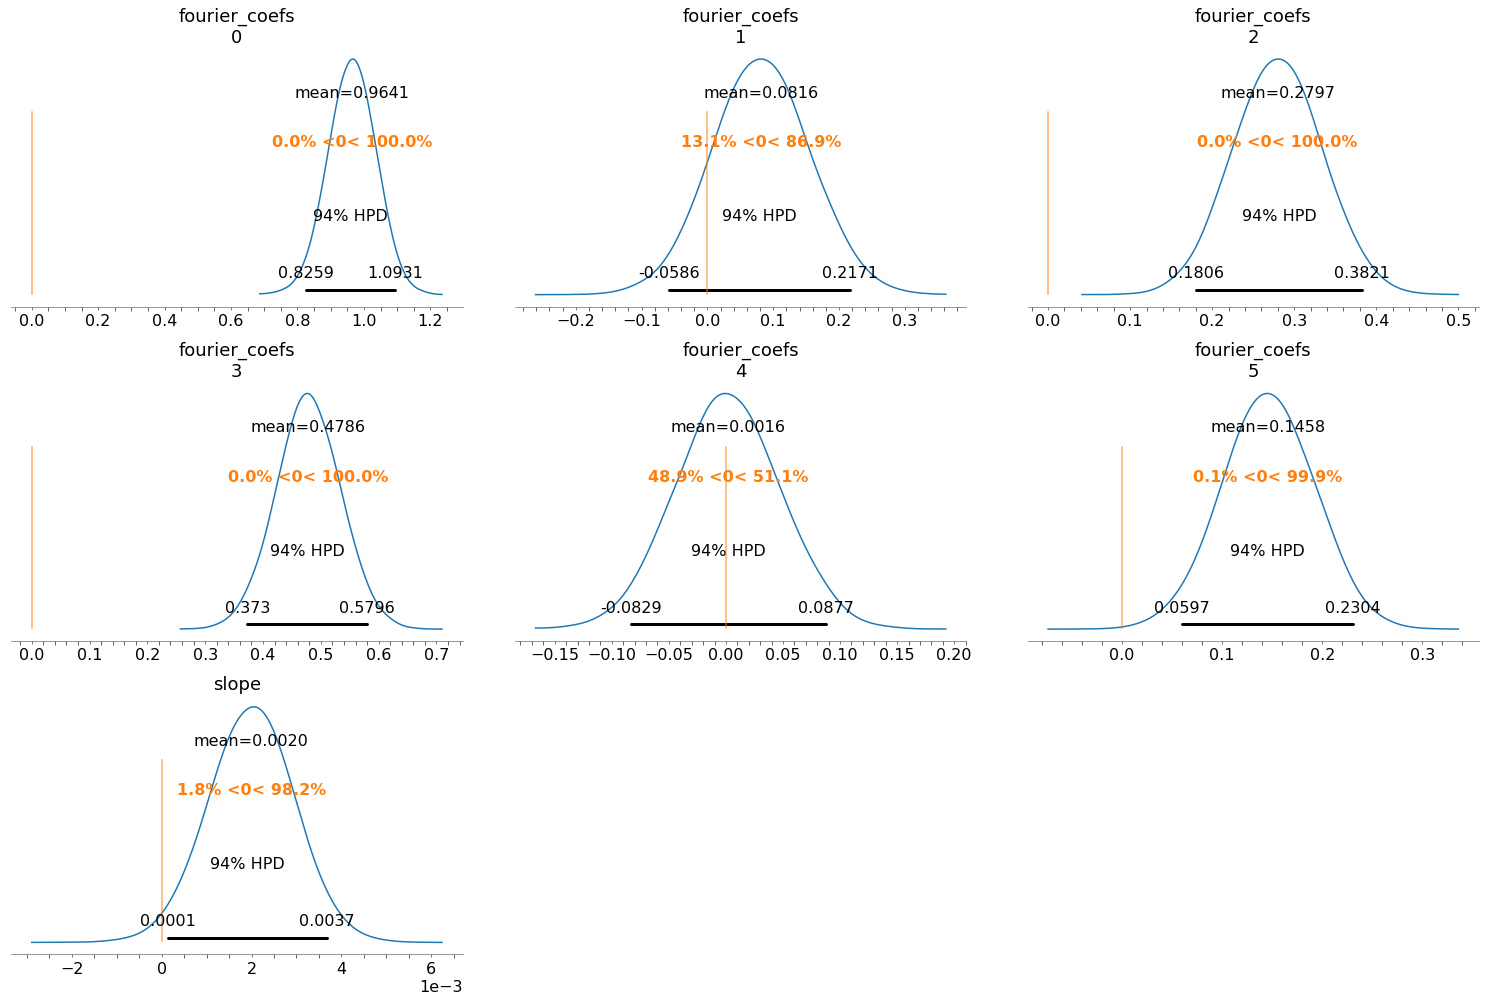

In [81]:
pm.plot_posterior(trace4_f3, var_names=vars_, ref_val=0, round_to=4);

In [93]:
m4_f4.name='trend&fourier4&ar1'
m4_f3.name='trend&fourier3&ar1'

In [95]:
pm.compare({m4_f4: trace4_f4, m4_f3:trace4_f3})

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/pymc3/stats.py:300: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO    pLOO   dLOO weight     SE   dSE shape_warn
trend&fourier4&ar1  349.92  131.05      0      1   17.7     0          1
trend&fourier3&ar1  364.21   132.6  14.28      0  19.24  6.74          1

Keeping the model with 4 fourier components:

In [96]:
dict_compare_final.update({m4_f4: trace4_f4})

In [99]:
pm.compare({m3_f1: trace_3f1, m3_f3: trace_3f3, })

TypeError: Missing required input: k_interval__

Compare and select all models so far written

In [113]:
ts_mod_4 = trace_4.get_values('mu')
ts_mod_4_mu = ts_mod_4.mean(axis=0)
ts_mod_4_hpd = pm.hpd(ts_mod_4)
ts_mod_4_trend = trace_4.get_values('trend')
ts_mod_4_trend_mu = ts_mod_4_trend.mean(axis=0)
ts_mod_4_trend_hpd = pm.hpd(ts_mod_4_trend)
ts_mod_4_season = trace_4.get_values('season')
ts_mod_4_season_mu = ts_mod_4_season.mean(axis=0)
ts_mod_4_season_hpd = pm.hpd(ts_mod_4_season)
ts_mod_4_ar1 = trace_4.get_values('ar1')
ts_mod_4_ar1_mu = ts_mod_4_ar1.mean(axis=0)
ts_mod_4_ar1_hpd = pm.hpd(ts_mod_4_ar1)

In [114]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

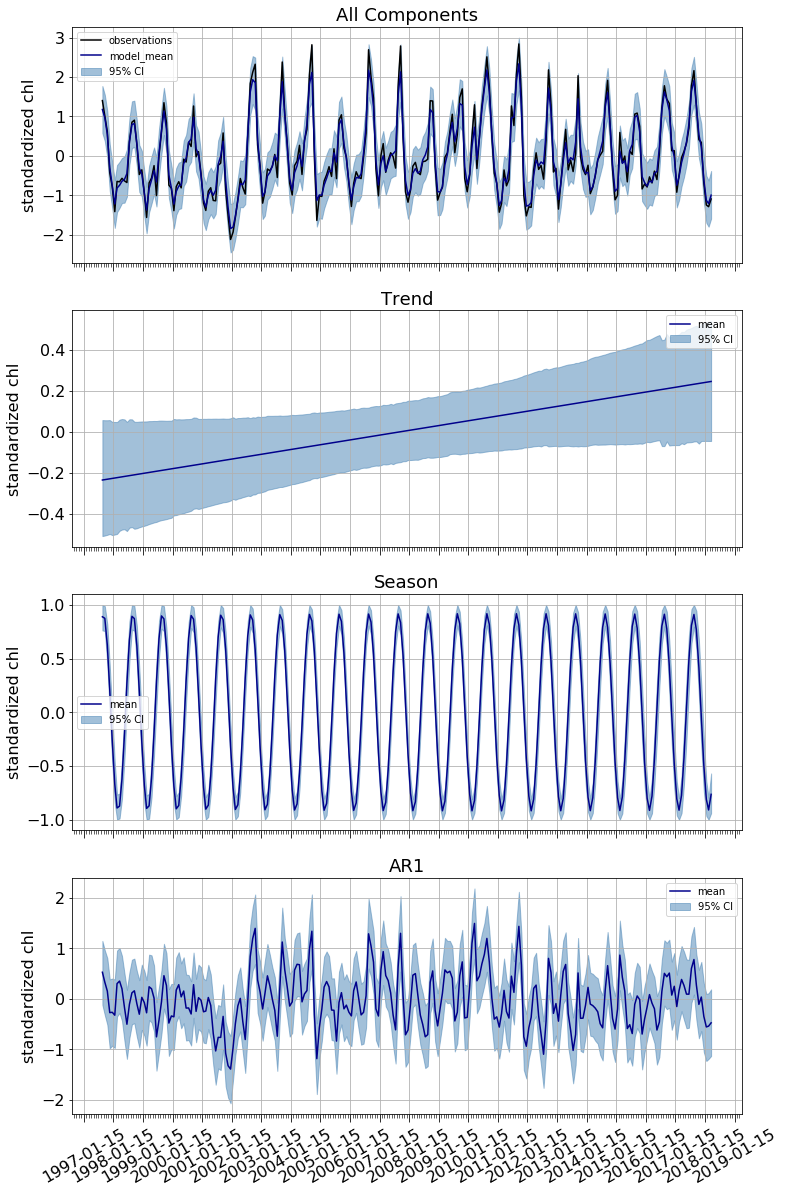

In [116]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))

ylbl = 'standardized chl'
plot_component(ax[0], d_aostz.index, ts_mod_4_mu, hpd_=ts_mod_4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_aostz.index, ts_mod_4_trend_mu, hpd_=ts_mod_4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_aostz.index, ts_mod_4_season_mu, hpd_=ts_mod_4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_aostz.index, ts_mod_4_ar1_mu, hpd_=ts_mod_4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')

#### Inverse transform results of models where standardized data was used

In [117]:
mod4_mu_us = std_scaler.inverse_transform(ts_mod_4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_mod_4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_mod_4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_mod_4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_mod_4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_mod_4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_mod_4_ar1_mu)

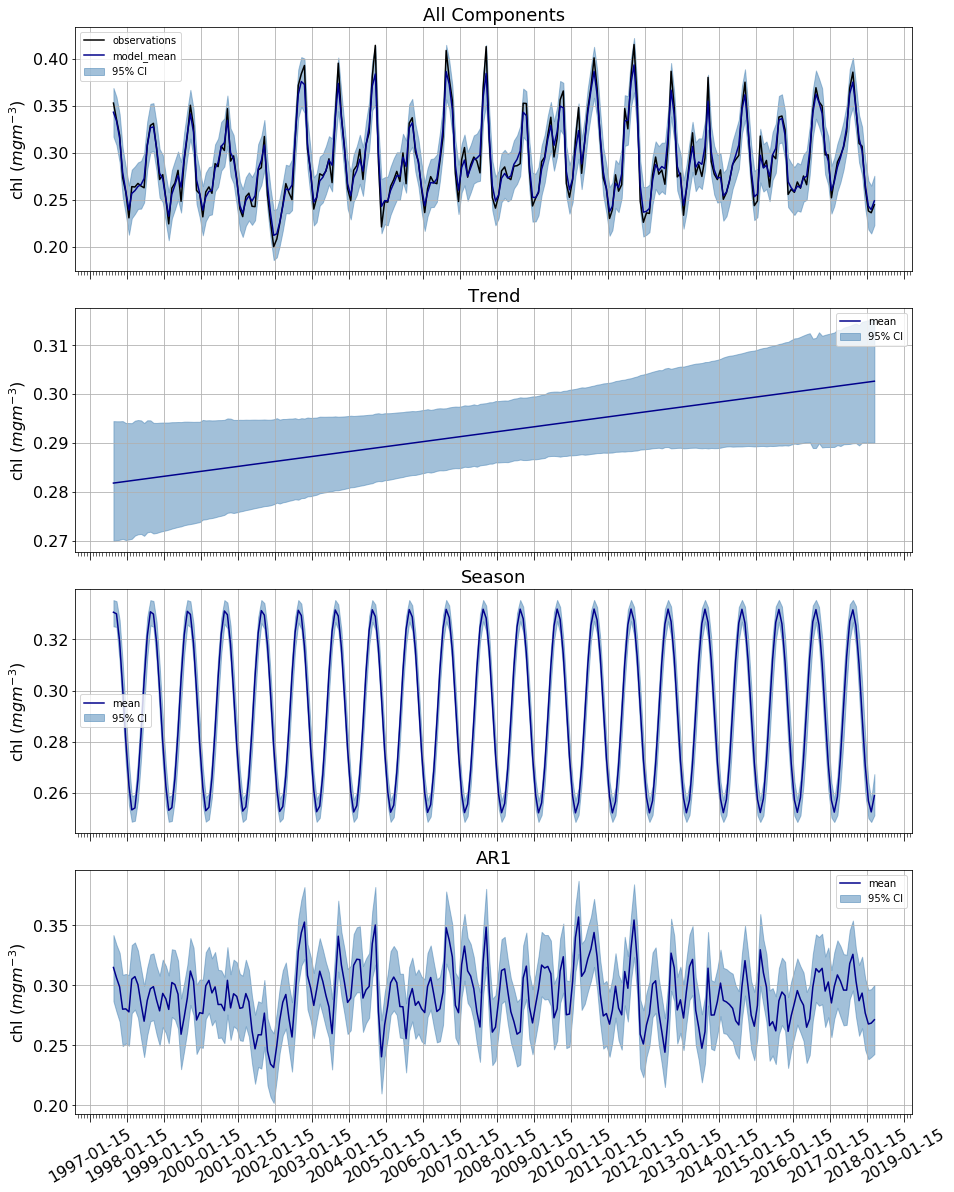

In [120]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(15, 20))
plot_component(ax[0], d_aostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_aostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_aostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_aostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')
f.subplots_adjust(hspace=0.15)

In [121]:
pm.summary(trace_4, var_names=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
intercept -0.235627  0.143825  0.003040 -0.508702  0.056463  2213.325831   
slope      0.001943  0.001017  0.000020 -0.000068  0.003934  2309.361144   
amp        0.923157  0.056201  0.000812  0.815722  0.999994  5024.418309   
k          0.489240  0.070586  0.000899  0.353786  0.629992  5713.613825   
tau        3.426348  0.493778  0.007132  2.507752  4.396493  5060.550056   
thresh     0.442741  0.278891  0.005672  0.000062  0.966938  2087.077726   
wl         1.905675  0.003887  0.000069  1.897961  1.913024  2810.873374   

               Rhat  
intercept  1.000190  
slope      1.000022  
amp        1.000534  
k          1.001168  
tau        1.000032  
thresh     1.000229  
wl         1.000813

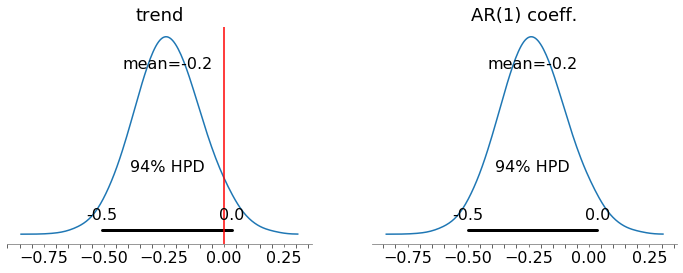

In [131]:
f, axs = pl.subplots(ncols=2, figsize=(12, 4))
pm.plot_posterior(trace_4, var_names=['trend', 'k'], ax=axs, text_size=16, );
axs[0].set_title('trend')
axs[0].axvline(color='r')
axs[1].set_title('AR(1) coeff.');
#f.savefig('./figJar/model4_posterior_dists.png', dpi=300)

In [125]:
with pm.Model() as m5:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    phase = pm.DiscreteUniform('phase', 0, 11, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    cycle_1 = pm.Uniform('cycle_1', 11, 13)
    cycle_2 = pm.Uniform('cycle_2', 5, 7)
    season_1 = amp[0] * tt.cos((2 * PI * x / cycle_1) - phase[0])
    season_2 = amp[1] * tt.cos((2 * PI * x / cycle_2) - phase[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)    

In [126]:
with m5:
    trace_5 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [ar1, tau, k, intercept, slope, cycle_2, cycle_1, amp, lam, nuMinusOne]
>Metropolis: [phase]
Sampling 2 chains: 100%|██████████| 40000/40000 [05:14<00:00, 127.09draws/s]
The acceptance probability does not match the target. It is 0.8932387184013946, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


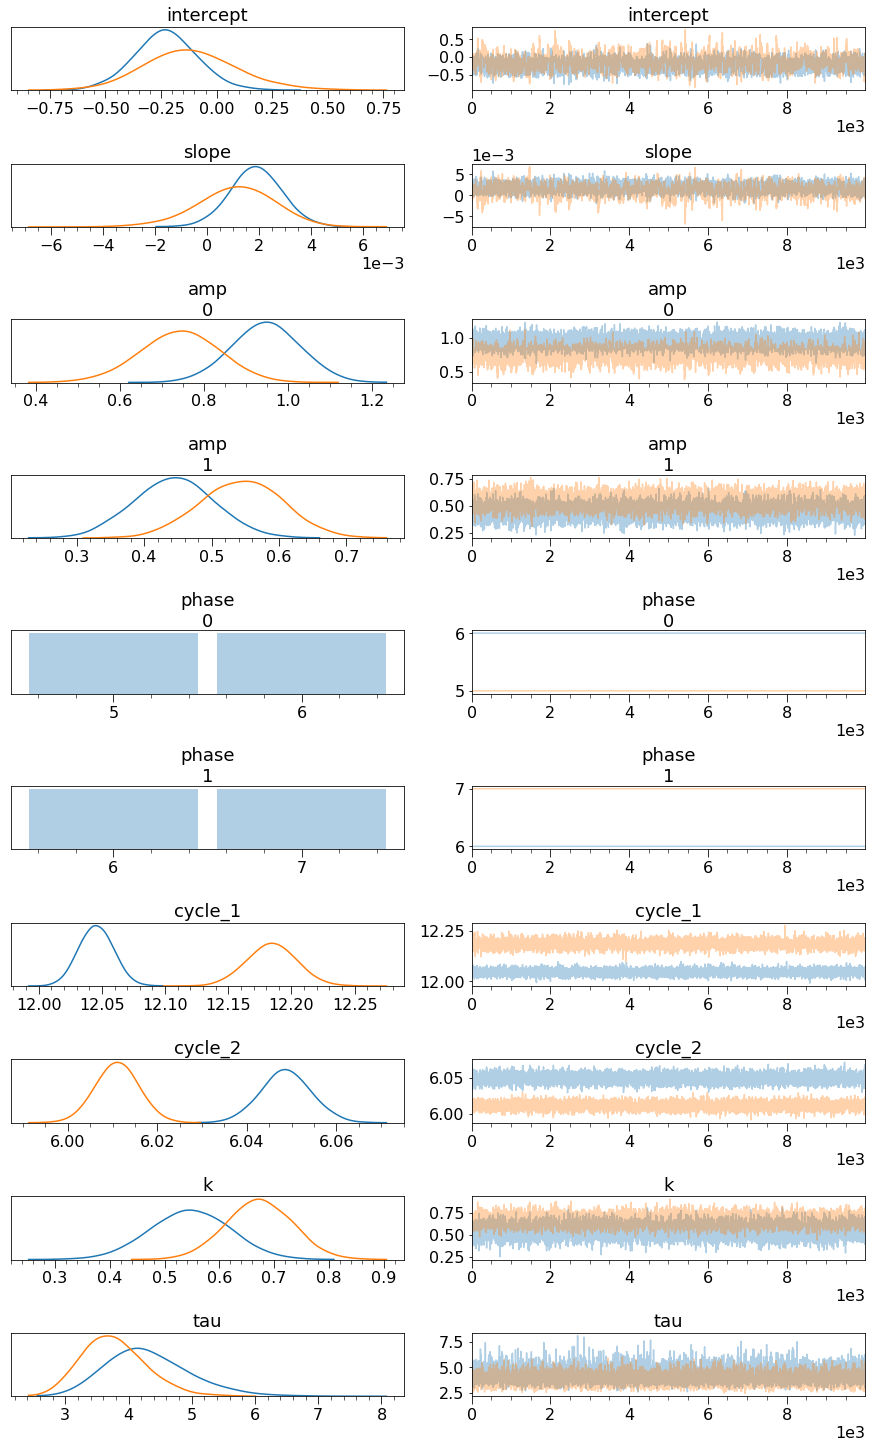

In [127]:
vars_ = ['intercept', 'slope', 'amp', 'phase', 'cycle_1' ,'cycle_2', 'k', 'tau']
pm.traceplot(trace_5, var_names=vars_);

In [178]:
dft5 = pm.summary(trace_5)

In [180]:
dft5.loc[dft5.Rhat>=1.4]

mean        sd  mc_error   hpd_2.5  hpd_97.5     n_eff       Rhat
phase  3.239477  2.731951  0.272014  1.169907  8.239232  2.013667  12.367996

In [65]:
ts_mod_5 = trace_5.get_values('mu_')
ts_mod_5_mu = ts_mod_5.mean(axis=0)
ts_mod_5_hpd = pm.hpd(ts_mod_5)
ts_mod_5_trend = trace_5.get_values('trend')
ts_mod_5_trend_mu = ts_mod_5_trend.mean(axis=0)
ts_mod_5_trend_hpd = pm.hpd(ts_mod_5_trend)
ts_mod_5_season = trace_5.get_values('season')
ts_mod_5_season_mu = ts_mod_5_season.mean(axis=0)
ts_mod_5_season_hpd = pm.hpd(ts_mod_5_season)
ts_mod_5_ar1 = trace_5.get_values('ar1')
ts_mod_5_ar1_mu = ts_mod_5_ar1.mean(axis=0)
ts_mod_5_ar1_hpd = pm.hpd(ts_mod_5_ar1)

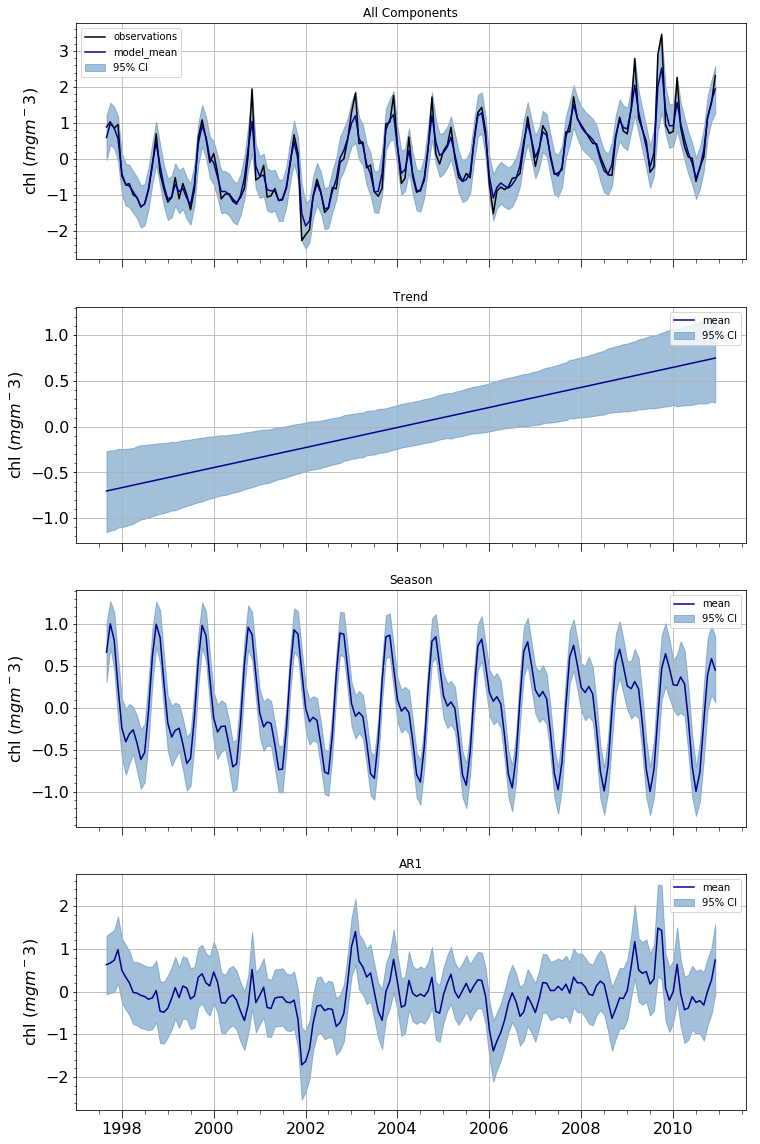

In [71]:
mod5_mu_us = std_scaler.inverse_transform(ts_mod_5_mu)
mod5_hpd_us = std_scaler.inverse_transform(ts_mod_5_hpd)
mod5_trend_hpd_us = std_scaler.inverse_transform(ts_mod_5_trend_hpd)
mod5_trend_mu_us = std_scaler.inverse_transform(ts_mod_5_trend_mu)
mod5_season_hpd_us = std_scaler.inverse_transform(ts_mod_5_season_hpd)
mod5_season_mu_us = std_scaler.inverse_transform(ts_mod_5_season_mu)
mod5_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_5_ar1_hpd)
mod5_ar1_mu_us = std_scaler.inverse_transform(ts_mod_5_ar1_mu)
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, ts_mod_5_mu, hpd_=ts_mod_5_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_5_trend_mu, hpd_=ts_mod_5_trend_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_5_season_mu, hpd_=ts_mod_5_season_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_5_ar1_mu, hpd_=ts_mod_5_ar1_hpd,
              line_label='mean', y_axis_label='chl $(mg m^-3)$', ax_title='AR1')

In [69]:
pm.summary(trace_5, var_names=vars_)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  -0.702773  0.226080  0.003271  -1.155062  -0.269016   4582.773666   
slope       0.009147  0.002464  0.000033   0.004332   0.014028   4829.893189   
amp__0      0.667671  0.110026  0.001155   0.450880   0.884505   8872.234845   
amp__1      0.393080  0.079475  0.000726   0.235134   0.549326  15881.738046   
thresh1    10.480064  0.469853  0.004725   9.573454  11.410631  12139.127125   
thresh2    11.552481  0.319111  0.002500  10.936431  12.193348  17125.299113   
wl_1        1.941707  0.011422  0.000106   1.919245   1.964353  11516.422607   
wl_2        0.955897  0.003947  0.000034   0.948013   0.963453  15734.391590   

               Rhat  
intercept  1.000160  
slope      1.000418  
amp__0     1.000059  
amp__1     1.000081  
thresh1    1.000228  
thresh2    1.000086  
wl_1       1.000208  
wl_2       1.000164

#### Modeling w/ missing data imputation

In [126]:
df[['IOSTZ']].resample('MS').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1997-09-01 to 2010-12-01
Freq: MS
Data columns (total 1 columns):
IOSTZ    155 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


In [144]:
y_w_nan = np.ma.array(data=df.IOSTZ.resample('MS').mean(),
                      mask=df.IOSTZ.resample('MS').mean().isnull(),
                     fill_value=-999)
nan_scaler = namedtuple('nan_scaler', ['mean_', 'std_'])
nan_scaler.mean_ = y_w_nan.mean()
nan_scaler.std_ = y_w_nan.std()
y_w_nan_s = (y_w_nan - nan_scaler.mean_) / nan_scaler.std_

In [146]:
with pm.Model() as m4i:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)

In [147]:
with m4i:
    trace_4i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [03:02<00:00, 109.84it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.69781933688, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71646233209, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


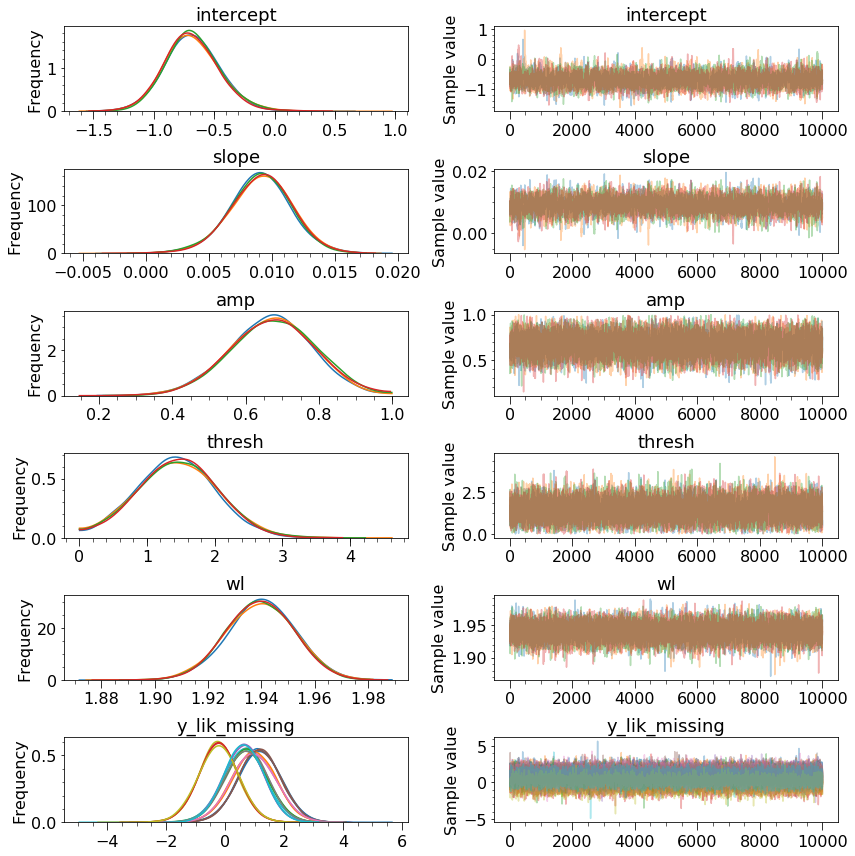

In [243]:
vars_ = ['intercept', 'slope', 'amp', 'thresh', 'wl', 'y_lik_missing']
pm.traceplot(trace_4i, varnames=vars_);

In [244]:
pm.summary(trace_4i, varnames=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept        -0.678875  0.224528  0.004561 -1.112781 -0.228108   
slope             0.009113  0.002447  0.000046  0.004178  0.013920   
amp               0.672759  0.114928  0.001340  0.441977  0.892130   
thresh            1.447370  0.584646  0.006425  0.289872  2.574037   
wl                1.939780  0.012613  0.000140  1.915247  1.964524   
y_lik_missing__0  1.166311  0.710226  0.004355 -0.219344  2.560616   
y_lik_missing__1  0.977485  0.743502  0.004838 -0.492352  2.421179   
y_lik_missing__2  0.711867  0.707809  0.004417 -0.682458  2.093423   
y_lik_missing__3 -0.222968  0.656253  0.003800 -1.539396  1.040424   
y_lik_missing__4  0.637990  0.663471  0.003682 -0.668910  1.927358   

                         n_eff      Rhat  
intercept          3116.003596  1.000485  
slope              3576.453879  1.000292  
amp                7069.847140  1.000799  
thresh             8414.914112  1.000438  
wl                 8984.735723  1.000503  
y_lik_missing__0  23333.505362  1.000090  
y_lik_missing__1  21163.169051  1.000011  
y_lik_missing__2  21569.211968  1.000060  
y_lik_missing__3  30058.771240  1.000005  
y_lik_missing__4  32088.705741  0.999994

In [192]:
d_iostz_s = (df.IOSTZ  - df.IOSTZ.mean()) / df.IOSTZ.std()
d_iostz_si = d_iostz_s.resample('MS').mean().interpolate()

In [198]:
np.argwhere(y_w_nan_s.mask)

array([[124],
       [125],
       [126],
       [130],
       [140]])

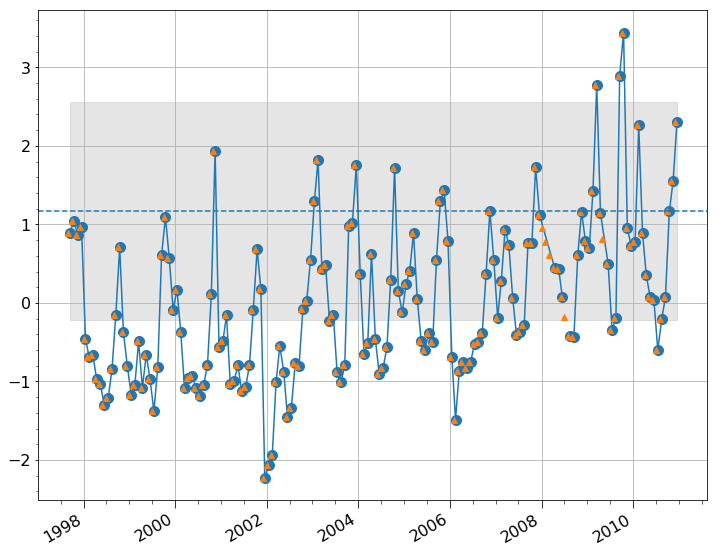

In [202]:
_, ax = pl.subplots(figsize=(12, 10))

d_iostz_s.plot(marker='o', markersize=10, ax=ax)
d_iostz_si.plot(marker='^', ls='', ax=ax)
ax.grid()
ax.axhline(y=1.166, ls='--')
ax.fill_between(d_iostz_s.index, y1=-0.219, y2=2.561, color='gray', alpha=0.2)

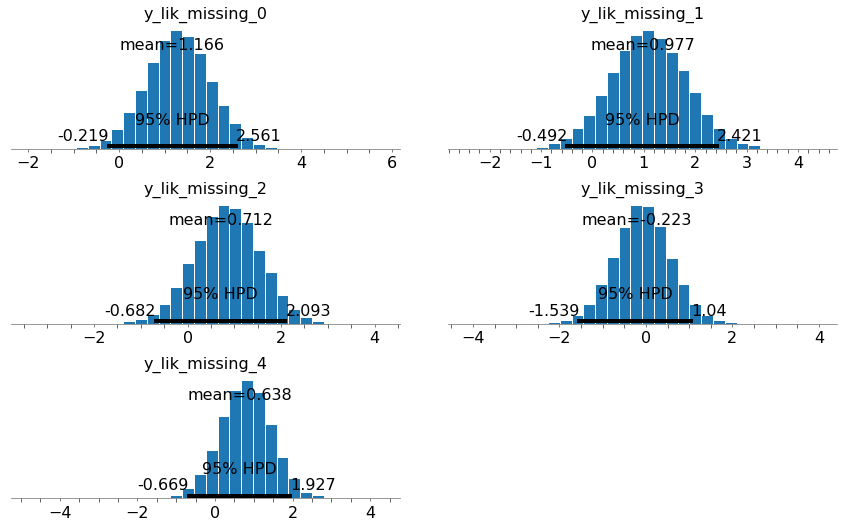

In [185]:
pm.plot_posterior(trace_4i, varnames=['y_lik_missing'],text_size=16);

In [166]:
with pm.Model() as m5i:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Normal('thresh', 10, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    wl = pm.Uniform('wl_1', 0, 5, shape=2)
    season_1 = amp[0] * tt.sin((x - thresh[0]) / wl[0])
    season_2 = amp[1] * tt.sin((x - thresh[1]) / wl[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)    

In [162]:
with m5i:
    trace_5i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_2_interval__, wl_1_interval__, amp_log__, thresh2, thresh1, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [04:49<00:00, 69.07it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


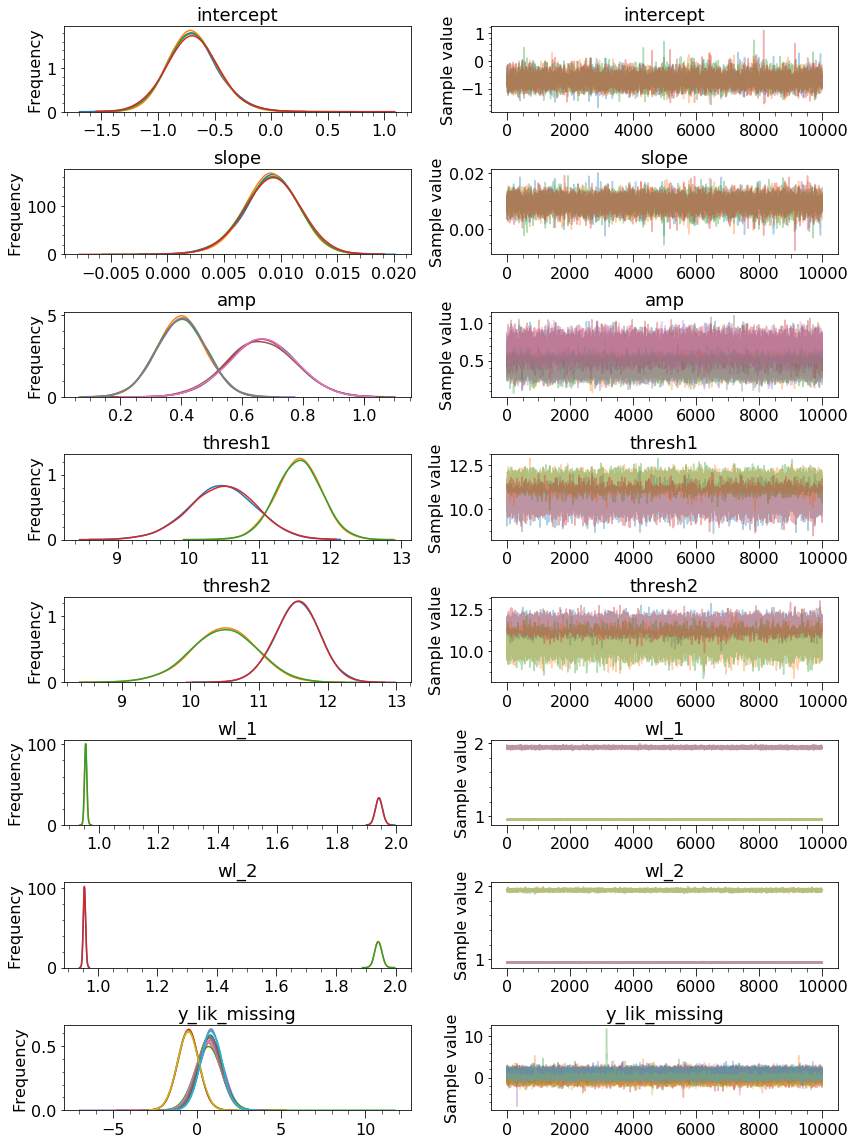

In [165]:
vars_ = ['intercept', 'slope', 'amp', 'thresh1', 'thresh2', 'wl_1', 'wl_2',
         'y_lik_missing']
pm.traceplot(trace_5i, varnames=vars_);

### Local linear  modeling

In [217]:
numobs = y_s.size

In [219]:
with pm.Model() as m6:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=delta_t, sd=1, observed=y_s)

In [220]:
with m6:
    trace_6 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_t]
100%|██████████| 10000/10000 [00:23<00:00, 425.11it/s]


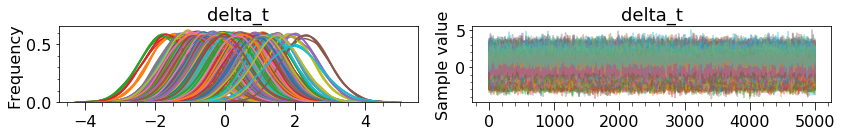

In [223]:
pm.traceplot(trace_6);

In [227]:
y_ppc6 = pm.sample_ppc(trace_6, model=m6)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6327.71it/s]


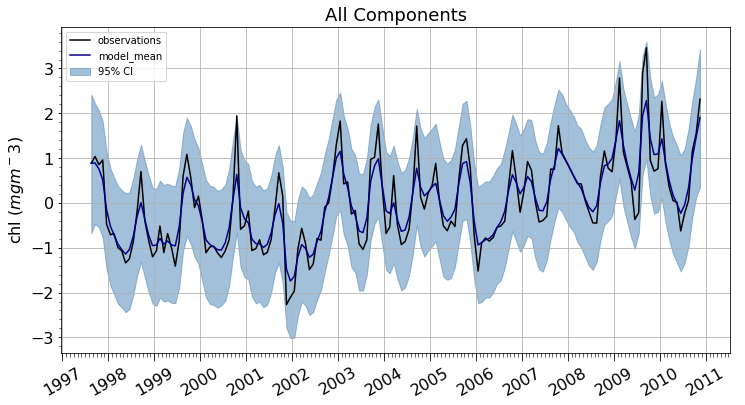

In [222]:
ts_mod_6 = trace_6.get_values('delta_t')
ts_mod_6_mu = ts_mod_6.mean(axis=0)
ts_mod_6_hpd = pm.hpd(ts_mod_6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, ts_mod_6_mu, hpd_=ts_mod_6_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

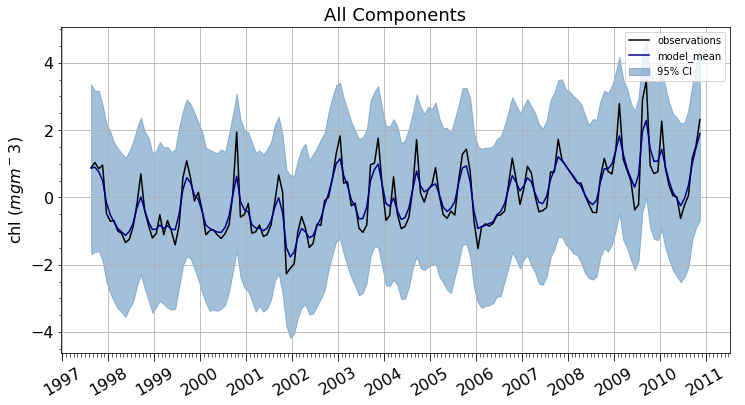

In [231]:
y_m6 = y_ppc6.mean(axis=0)
hpd6 = pm.hpd(y_ppc6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m6, hpd_=hpd6,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Local linear trend modeling

In [224]:
with pm.Model() as m7:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs-1)
    nu_t = pm.GaussianRandomWalk('nu_t', mu=delta_t, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=nu_t, sd=1, observed=y_s)

In [225]:
with m7:
    trace_7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_t, delta_t]
100%|██████████| 10000/10000 [00:19<00:00, 505.28it/s]


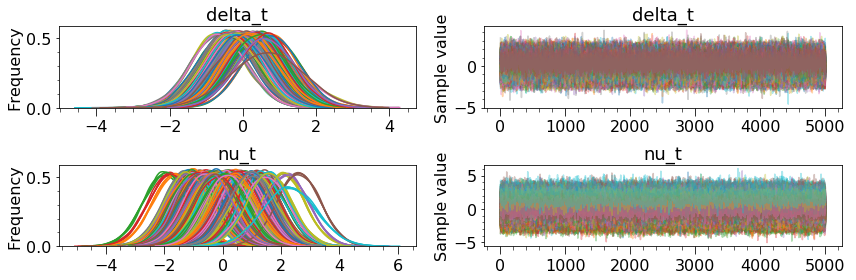

In [226]:
pm.traceplot(trace_7);

In [232]:
y_ppc7 = pm.sample_ppc(trace_7, model=m7)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6284.92it/s]


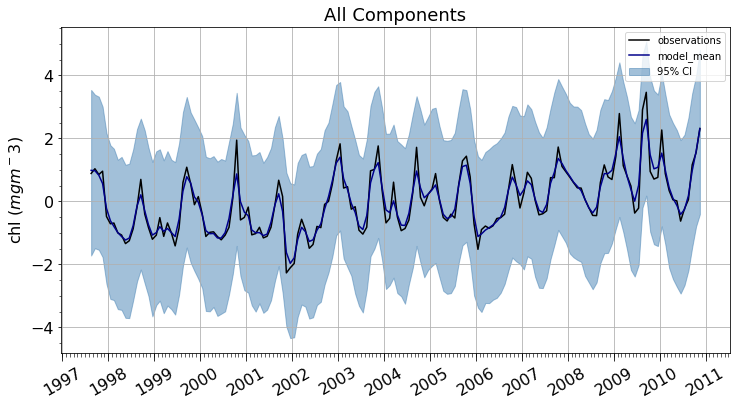

In [233]:
y_m7 = y_ppc7.mean(axis=0)
hpd7 = pm.hpd(y_ppc7)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m7, hpd_=hpd7,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Pickle model results and scaler

In [88]:
m5.name = 'm5'
m4.name = 'm4'
m4i.name = 'm4_imputed'
m5i.name = 'm5_imputed'
resDict = dict(models=dict(m4=m4, m5=m5, m4i=m4i, m5i=m5i),
               traces=dict(m4=trace_4, m5=trace_5, m4i=trace_4i, m5i),
               scaler=std_scaler)
with open('./pikleJar/iostz_bayMdl.pkl', 'wb') as f:
    pickle.dump(resDict, f)

'm5'

In [79]:
resDict.keys(), resDict['models'].keys(), resDict['traces'].keys()

(dict_keys(['models', 'traces', 'scaler']),
 dict_keys(['m4', 'm5']),
 dict_keys(['m4', 'm5']))

In [94]:
pm.compare({m4:trace_4, m5:trace_5})

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE   dSE var_warn
m5  239.66  73.83      0      1  20.75     0        1
m4  254.37  77.72  14.71      0  20.88  5.75        1

In [95]:
pm.compare({m4:trace_4, m5:trace_5}, ic='LOO')

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO   pLOO   dLOO weight     SE   dSE shape_warn
m5  268.39  88.19      0      1  21.25     0          1
m4  286.86  93.96  18.47      0  21.22  6.28          1


 #### <u>Piecewise trend model</u>